<a href="https://colab.research.google.com/github/Engrgit/Curacel-tasks/blob/main/accidented_car_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

![alt text](https://tse3.mm.bing.net/th?id=OIP.UkPPlVHOiOdzOmwzuBrrqwHaBl&pid=Api&P=0&w=517&h=110)
Machine learning Model for Detecting Accidented Cars from Non-Accidented Cars
==============================================
**Author**: Ibrahim Gbadegesin

**Github**: <https://github.com/Engrgit/Curacel-tasks>


Mount your drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


Import some python libraries

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Change to dataset directory

In [5]:
data_directory = "/content/drive/My Drive/Curacel_ai_engine"
os.chdir(data_directory)

#Lets do data preprocessing
The goal is to clean the data and rename for ease

In [ ]:
#train_dir = "/content/drive/My Drive/Curacel_ai_engine/car_data/train"
#val_dir = "/content/drive/My Drive/Curacel_ai_engine/car_data/val"
 

In [ ]:
#Replace data_directory with train_dir and val_dir respectively and run the block for each case.
#data_directory = "/content/drive/My Drive/Curacel_ai_engine/car_data/val"
#os.chdir(data_directory)

In [ ]:
# This block helps in proper numbering of the data and formating in .jpg
#import os
#for dirname in os.listdir("."):
#    if os.path.isdir(dirname):
#        for i, filename in enumerate(os.listdir(dirname)):
#            os.rename(dirname + "/" + filename, dirname + "/" + str(i) + ".jpg")

Load Data
---------

The problem is to train a model to classify
**accidented cars** from **non-accidented cars**. For the sake of brevity, we will abstract the accidented cars as **a_cars** and non-accidented cars as **n_cars**.
We have about 990 training images each for a_cars and n_cars.
In the validation data pool, there are 1010 images for n_cars and 1000 images for a_cars.

I will be using all of the training sets and using a fractional part of the validation set. The rule of tumb is 70:30 ratio split between the training and the validation set. 
If 0.7 of x = 990 images. Then x is 990/0.7 = 1424. Then 0.3 of 1414 = 424.

Hence, I will be using 424 images from the validation sets. The rest of the images will be used to test the model after building.

I will be using a pretrained model to improve model learning due to data small size. Kindly follow me on this ride.


In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'data/hymenoptera_data'  # change this
data_dir = "/content/drive/My Drive/Curacel_ai_engine/car_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's visualize a few training images so as to understand the data
augmentations.



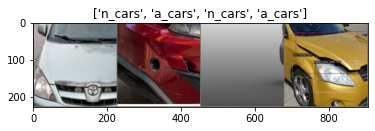

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Lets visualize the model predictions. Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [10]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Lets train and evaluate. It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.



In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5430 Acc: 0.7758
val Loss: 0.4249 Acc: 0.8632

Epoch 1/24
----------
train Loss: 0.4712 Acc: 0.8253
val Loss: 0.2504 Acc: 0.8986

Epoch 2/24
----------
train Loss: 0.4353 Acc: 0.8268
val Loss: 0.2531 Acc: 0.9057

Epoch 3/24
----------
train Loss: 0.4066 Acc: 0.8338
val Loss: 0.3903 Acc: 0.8538

Epoch 4/24
----------
train Loss: 0.3149 Acc: 0.8848
val Loss: 0.2472 Acc: 0.8880

Epoch 5/24
----------
train Loss: 0.2404 Acc: 0.9035
val Loss: 0.3808 Acc: 0.8219

Epoch 6/24
----------
train Loss: 0.2493 Acc: 0.9045
val Loss: 0.4700 Acc: 0.7913

Epoch 7/24
----------
train Loss: 0.1597 Acc: 0.9374
val Loss: 0.2916 Acc: 0.8774

Epoch 8/24
----------
train Loss: 0.1340 Acc: 0.9551
val Loss: 0.2650 Acc: 0.8856

Epoch 9/24
----------
train Loss: 0.1410 Acc: 0.9470
val Loss: 0.2942 Acc: 0.8726

Epoch 10/24
----------
train Loss: 0.1197 Acc: 0.9520
val Loss: 0.2841 Acc: 0.8821

Epoch 11/24
----------
train Loss: 0.1268 Acc: 0.9571
val Loss: 0.2943 Acc: 0.8656

Epoch 12/24
----------
t

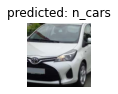

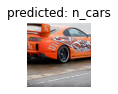

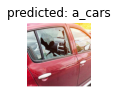

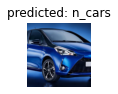

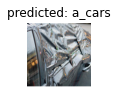

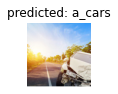

In [12]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.




In [14]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.



In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4973 Acc: 0.7672
val Loss: 0.3463 Acc: 0.8608

Epoch 1/24
----------
train Loss: 0.6200 Acc: 0.7601
val Loss: 0.5128 Acc: 0.8054

Epoch 2/24
----------
train Loss: 0.4758 Acc: 0.8010
val Loss: 0.3572 Acc: 0.8632

Epoch 3/24
----------
train Loss: 0.4778 Acc: 0.8086
val Loss: 0.2795 Acc: 0.8844

Epoch 4/24
----------
train Loss: 0.4942 Acc: 0.7939
val Loss: 0.3342 Acc: 0.8644

Epoch 5/24
----------
train Loss: 0.4764 Acc: 0.8025
val Loss: 0.2987 Acc: 0.8644

Epoch 6/24
----------
train Loss: 0.5076 Acc: 0.7939
val Loss: 0.3034 Acc: 0.8844

Epoch 7/24
----------
train Loss: 0.4009 Acc: 0.8419
val Loss: 0.2823 Acc: 0.8844

Epoch 8/24
----------
train Loss: 0.3545 Acc: 0.8510
val Loss: 0.3199 Acc: 0.8703

Epoch 9/24
----------
train Loss: 0.3347 Acc: 0.8500
val Loss: 0.2883 Acc: 0.8726

Epoch 10/24
----------
train Loss: 0.3717 Acc: 0.8455
val Loss: 0.3013 Acc: 0.8750

Epoch 11/24
----------
train Loss: 0.3279 Acc: 0.8626
val Loss: 0.2921 Acc: 0.8774

Ep

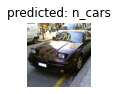

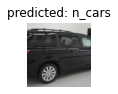

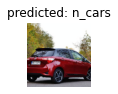

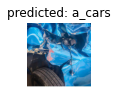

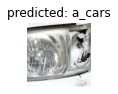

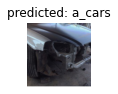

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [17]:
torch.save(model_conv, 'model.pth')

# Demo Instructions
   If you follow the following steps to run this notebook. You will get my result.
    
    1) kindly change all directories to conform with the codebase in this notebook

        data_dir = "/content/drive/My Drive/Curacel_ai_engine/car_data"
        train_dir = "/content/drive/My Drive/Curacel_ai_engine/car_data/train"
        val_dir = "/content/drive/My Drive/Curacel_ai_engine/car_data/val"
    
        Remember:
           Accidented car = a_car
           Non_Accidented car = n_car

    2) Use the inference api at https://github.com/Engrgit/Curacel-tasks/tree/main/car_detection_api for testing  
    3) when you get model.pth output, copy it into the folder here -> Curacel-tasks/car_detection_api/ml_model/ 
    4) Test the Flask API by installing all the requirements
    5) Have a lovely day and enjoy tesing the model.


    Cheers
    Ibrahim